## ACP sur les eaux

**Description des données**  
On dispose d’un fichier comprenant les variables explicitées ci-dessous pour étudier 57 marques d’eaux en bouteille:  

**NOM** : le nom complet de l’eau inscrit sur l’étiquette.  
**PAYS** : le pays d’origine identifié par les lettres de l’immatriculation automobile officielle.  
**TYPE** : à deux modalités : M    pour  eau minérale ,     S    pour eau de source.  
**PG** : à deux modalités : P   pour eau plate,    G    pour eau gazeuse.  
**CA** : ions calcium en mg/litre.  
**MG** : ions magnésium en mg/litre.  
**NA** : ions sodium en mg/litre.  
**K** : ions potassium en mg/litre.  
**SUL** : ions sulfates en mg/litre.  
**NO3** : ions nitrates en mg/litre.  
**HCO3** : ions carbonates en mg/litre.  
**CL** : ions chlorures en mg/litre.  

##### RUBRIQUES

1. [IMPORT, VÉRIFICATION ET MANIPULATION DES DONNÉES](#import_check)  

2. [ANALYSE EXPLORATOIRE](#analyse_exploratoire)  

    2-1. [Analyse Univariée](#analyse_exploratoire_uni)
    
    2-2. [Analyse Bivariée](#analyse_exploratoire_bi)
    
    2-3. [Analyse Multivariée : ACP (basée sur la SVD)](#analyse_exploratoire_multi)  
    
    2-3-1. [Ajout des Variables illustratives](#analyse_exploratoire_multi_varsupp)

[REQUIREMENTS.txt](#requirements)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
from utils.funcs import heatmap, annotate_heatmap, V_Cramer

---

## <a id="import_check" style="color:black">1. IMPORT, VÉRIFICATION ET MANIPULATION DES DONNÉES</a>

In [3]:
df = pd.read_table("../data/csv-txt/eaux/donnees_eaux.txt", encoding="iso-8859-1")

In [4]:
df.head()

,NOM,ACRO,PAYS,TYPE,PG,CA,MG,NA,K,SUL,NO3,HCO3,CL
0,Evian,EVIAN,F,M,P,78,24,5,1,10,"3,8",357,"4,5"
1,Montagne des Pyrénées,MTPYR,F,S,P,48,11,34,1,16,4,183,50
2,Cristaline-St-Cyr,CRIST,F,S,P,71,"5,5","11,2","3,2",5,1,250,20
3,Fiée des Lois,FIEE,F,S,P,89,31,17,2,47,0,360,28
4,Volcania,VOLCA,F,S,P,"4,1","1,7","2,7","0,9","1,1","0,8","25,8","0,9"


In [5]:
df.columns = ["nom","acronyme","pays","type","pg","ca","mg","na","k","sul","no3","hco3","cl"]

In [6]:
df.head()

,nom,acronyme,pays,type,pg,ca,mg,na,k,sul,no3,hco3,cl
0,Evian,EVIAN,F,M,P,78,24,5,1,10,"3,8",357,"4,5"
1,Montagne des Pyrénées,MTPYR,F,S,P,48,11,34,1,16,4,183,50
2,Cristaline-St-Cyr,CRIST,F,S,P,71,"5,5","11,2","3,2",5,1,250,20
3,Fiée des Lois,FIEE,F,S,P,89,31,17,2,47,0,360,28
4,Volcania,VOLCA,F,S,P,"4,1","1,7","2,7","0,9","1,1","0,8","25,8","0,9"


In [7]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   nom       57 non-null     object
 1   acronyme  57 non-null     object
 2   pays      57 non-null     object
 3   type      57 non-null     object
 4   pg        57 non-null     object
 5   ca        57 non-null     object
 6   mg        57 non-null     object
 7   na        57 non-null     object
 8   k         57 non-null     object
 9   sul       57 non-null     object
 10  no3       57 non-null     object
 11  hco3      57 non-null     object
 12  cl        57 non-null     object
dtypes: object(13)
memory usage: 43.8 KB


On voit que toutes les variables, notamment celles sur les ions, sont des chaînes de caractères. Cela est dû aux virgules dans certains chiffres que nous allons les remplacer par des points (.).

In [8]:
df.iloc[:,5:] = df.iloc[:,5:].replace(",", ".", regex=True)

In [9]:
df.dtypes

nom         object
acronyme    object
pays        object
type        object
pg          object
ca          object
mg          object
na          object
k           object
sul         object
no3         object
hco3        object
cl          object
dtype: object

In [10]:
for i in df.columns[5:]:
    df[i] = pd.to_numeric(df[i])

In [11]:
df.dtypes

nom          object
acronyme     object
pays         object
type         object
pg           object
ca          float64
mg          float64
na          float64
k           float64
sul         float64
no3         float64
hco3        float64
cl          float64
dtype: object

In [12]:
df.isnull().sum()

nom         0
acronyme    0
pays        0
type        0
pg          0
ca          0
mg          0
na          0
k           0
sul         0
no3         0
hco3        0
cl          0
dtype: int64

In [13]:
# Pour détecter les chaînes de caractères vides

df.apply(lambda x: x == "", axis=1).sum()

nom         0
acronyme    0
pays        0
type        0
pg          0
ca          0
mg          0
na          0
k           0
sul         0
no3         0
hco3        0
cl          0
dtype: int64

In [15]:
# Describe sur les colonnes de type chaînes de caractères
df.iloc[:,:5].describe()

,nom,acronyme,pays,type,pg
count,57,57,57,57,57
unique,57,56,6,2,2
top,Evian,VERN,F,M,P
freq,1,2,40,38,41


In [16]:
# Describe des colonnes de type chaînes de caractère
df.select_dtypes(include=["object"]).describe()

,nom,acronyme,pays,type,pg
count,57,57,57,57,57
unique,57,56,6,2,2
top,Evian,VERN,F,M,P
freq,1,2,40,38,41


La colonne 'acronyme' a une valeur en double

In [17]:
df[df.duplicated(subset=["acronyme"], keep=False)]

,nom,acronyme,pays,type,pg,ca,mg,na,k,sul,no3,hco3,cl
42,Vernière,VERN,F,M,G,190.0,72.0,154.0,49.0,158.0,0.0,1170.0,18.0
53,Vernet,VERN,F,M,G,33.5,17.6,192.0,28.7,14.0,1.0,734.0,6.4


Deux valeurs d'acronyme qui se ressemblent pour deux eaux distinctes que l'n peut recoder pour éviter d'éventuelles erreurs

In [18]:
df.loc[df.nom == "Vernière", "acronyme"] = "VERNI"

In [19]:
# check

df.loc[df.nom == "Vernière", "acronyme"]

42    VERNI
Name: acronyme, dtype: object

## <a id="analyse_exploratoire" style="color:black">2. ANALYSE EXPLORATOIRE</a>

## <a id="analyse_exploratoire_uni" style="color:black">2-1. Analyse Univariée</a>

In [20]:
# Résumé des variables qualitatives
df.select_dtypes(include=["object"]).describe()

,nom,acronyme,pays,type,pg
count,57,57,57,57,57
unique,57,57,6,2,2
top,Evian,EVIAN,F,M,P
freq,1,1,40,38,41


In [21]:
# Modalités de pays
df.pays.unique()

array(['F', 'GRC', 'GR', 'IT', 'GB', 'MA'], dtype=object)

In [22]:
# Résumé des variables numériques
df.describe()

,ca,mg,na,k,sul,no3,hco3,cl
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,102.458246,25.861930,93.851754,11.090351,135.661404,3.834211,442.166842,52.473684
std,119.973168,28.298381,197.251354,24.435278,329.208286,6.669394,608.299850,143.249790
min,1.200000,0.200000,0.800000,0.000000,1.100000,0.000000,4.900000,0.300000
25%,36.000000,5.500000,5.000000,0.900000,9.000000,0.450000,154.000000,3.500000
50%,63.000000,12.000000,9.100000,2.000000,16.000000,1.500000,236.000000,14.200000
75%,116.000000,31.500000,36.000000,6.000000,43.000000,4.000000,360.000000,38.000000
max,528.000000,95.000000,968.000000,130.000000,1371.000000,35.600000,3380.510000,982.000000


In [23]:
numeric_cols = list(df.select_dtypes(exclude=["object"]).columns)
categorical_cols = ['pays','type','pg']

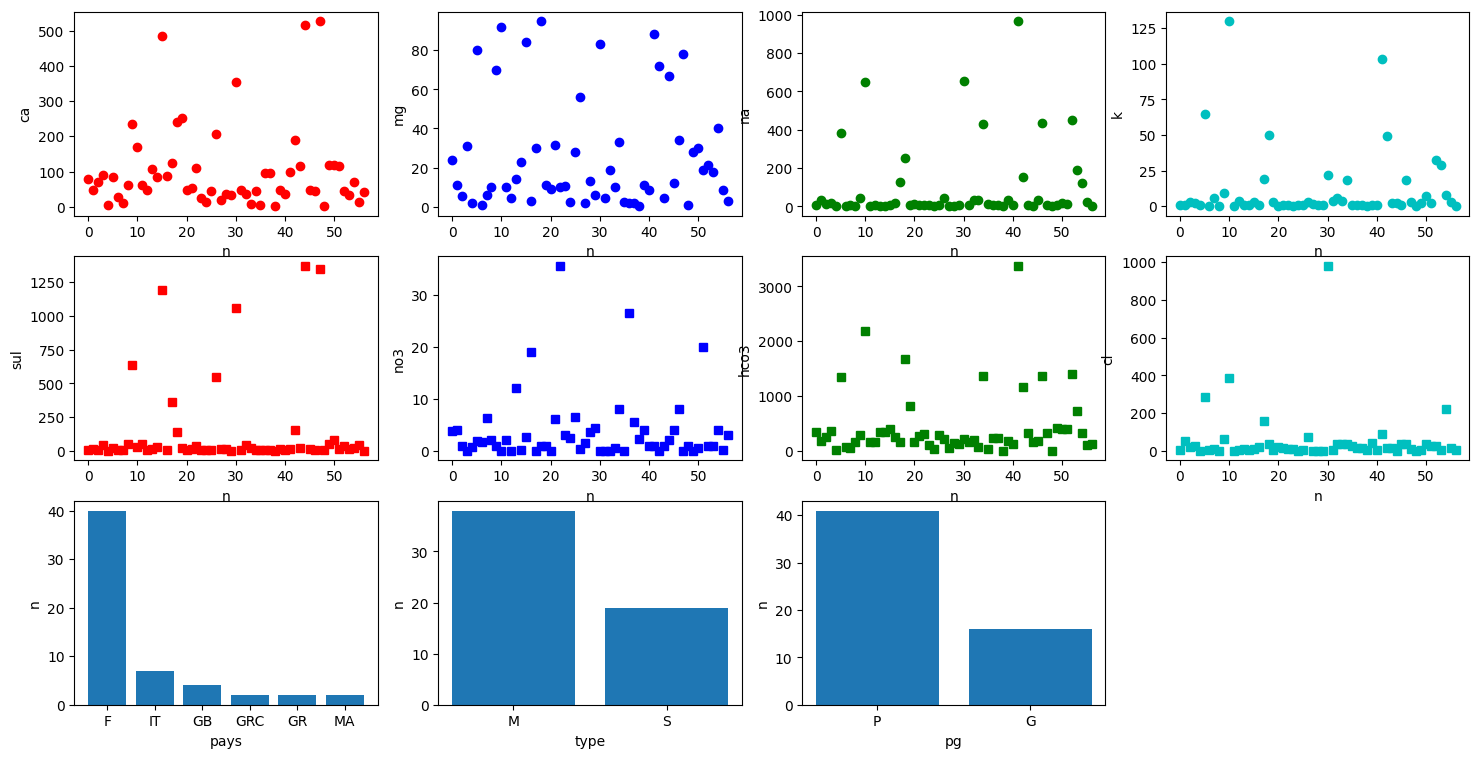

In [25]:
nrows = 3
ncols = 4
ls_colors = ['ro','bo','go','co','rs','bs','gs','cs']

plt.figure(figsize=[18,9])

for i, c in enumerate(zip(numeric_cols, ls_colors)):
    plt.subplot(nrows, ncols, i+1)
    plt.plot(df[c[0]], c[1])
    plt.xlabel("n")
    plt.ylabel(c[0])

for i, c in enumerate(categorical_cols, len(numeric_cols)):
    plt.subplot(nrows, ncols, i+1)
    plt.bar(df[c].value_counts().index, df[c].value_counts().values)
    plt.ylabel("n")
    plt.xlabel(c)

plt.show()

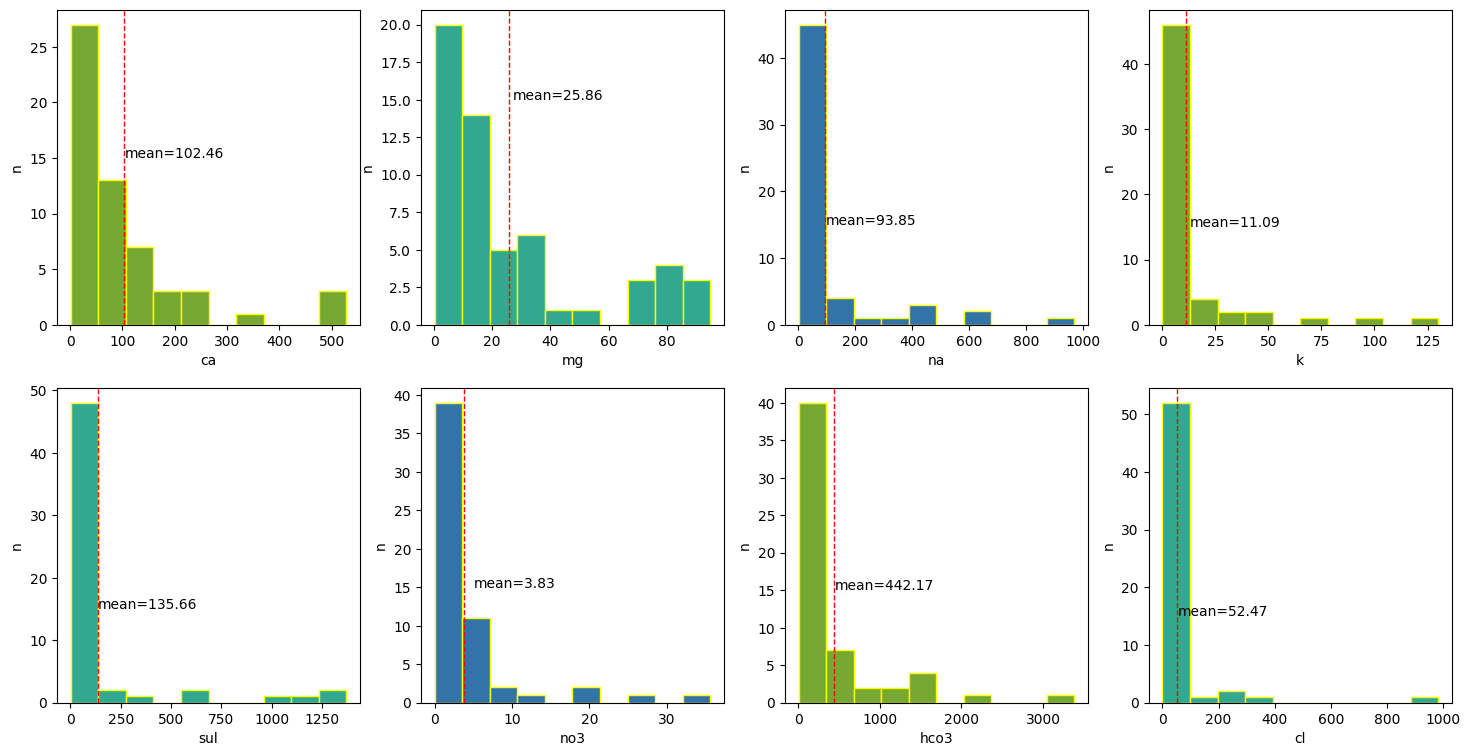

In [26]:
nrows = 2
ncols = 4
ls_colors = ['#77a832','#32a890','#3273a8','#77a832','#32a890','#3273a8','#77a832','#32a890']

plt.figure(figsize=[18,9])

for i, c in enumerate(zip(numeric_cols, ls_colors)):
    plt.subplot(nrows, ncols, i+1)
    plt.hist(df[c[0]], color=c[1], edgecolor="yellow")
    plt.axvline(df[c[0]].mean(), color='r', linestyle='dashed', linewidth=1)
    plt.xlabel(c[0])
    plt.ylabel("n")
    plt.annotate(f"mean={round(df[c[0]].mean(),2)}", xy=(int(df[c[0]].mean()), 4.5),
                xytext=(int(df[c[0]].mean()) + 2, 15))

plt.show()

In [27]:
# Test de normalité -- Shapiro-Wilk (intéressant pour petits échantillons)
# La 2e valeur correspond à la p-value

df.loc[:,numeric_cols].apply(stats.shapiro, axis=0)

,ca,mg,na,k,sul,no3,hco3,cl
0,7.008135e-01,7.869468e-01,5.302062e-01,4.891799e-01,4.405298e-01,5.796264e-01,6.210439e-01,3.592312e-01
1,1.758810e-09,1.134964e-07,3.096726e-12,8.626674e-13,2.075256e-13,1.608721e-11,7.117759e-11,2.311580e-14


In [28]:
# Test de normalité -- Agostino
df.loc[:,numeric_cols].apply(stats.normaltest, axis=0)

,ca,mg,na,k,sul,no3,hco3,cl
0,4.155760e+01,13.008466,5.105727e+01,6.608165e+01,5.382197e+01,6.087939e+01,5.620345e+01,1.002387e+02
1,9.459789e-10,0.001497,8.185679e-12,4.472528e-15,2.054510e-12,6.028475e-14,6.245635e-13,1.711758e-22


Au seuil de 5%, on rejette l'hypothèse H0 de normalité. Cohérent avec l'analyse graphique.

--------------------------------------------------------------------

## <a id="analyse_exploratoire_bi" style="color:black">2-2. Analyse Bivariée</a>

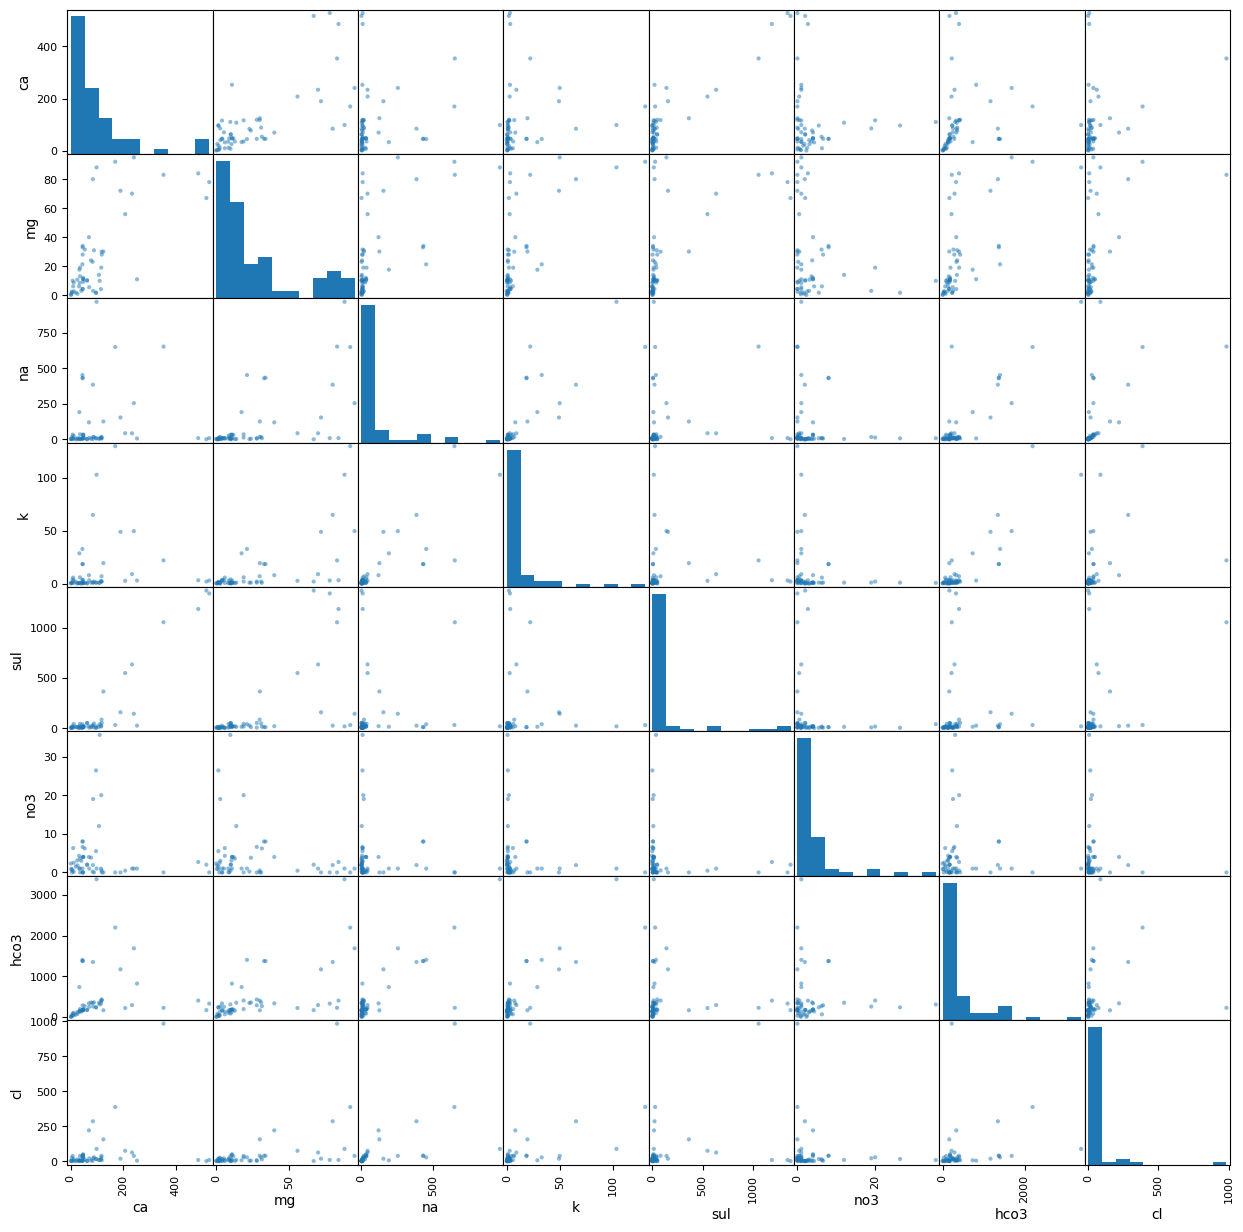

In [29]:
pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

In [30]:
print("Tableau de contingence entre pays et type d'eau (minérale/source)")
cross_type_pays = pd.crosstab(df.type, df.pays)
print(cross_type_pays)
print("\nV de Cramer:", V_Cramer(cross_type_pays), "\n")
print("=====================================================================")

print("Tableau de contingence entre pays et eau plate/gazeuse")
cross_pg_pays = pd.crosstab(df.pg, df.pays)
print(cross_pg_pays)
print("\nV de Cramer:", V_Cramer(cross_pg_pays), "\n")
print("=====================================================================")

print("Tableau de contingence entre eau plate/gazeuse et type d'eau (minérale/source)")
cross_type_pg = pd.crosstab(df.type, df.pg)
print(cross_type_pg)
print("\nV de Cramer:", V_Cramer(cross_type_pg), "\n")

Tableau de contingence entre pays et type d'eau (minérale/source)
pays   F  GB  GR  GRC  IT  MA
type                         
M     23   3   2    2   7   1
S     17   1   0    0   0   1

V de Cramer: 0.20261449005179116 

Tableau de contingence entre pays et eau plate/gazeuse
pays   F  GB  GR  GRC  IT  MA
pg                           
G     13   2   0    0   1   0
P     27   2   2    2   6   2

V de Cramer: 0.0 

Tableau de contingence entre eau plate/gazeuse et type d'eau (minérale/source)
pg     G   P
type        
M     13  25
S      3  16

V de Cramer: 0.07275844675554433 



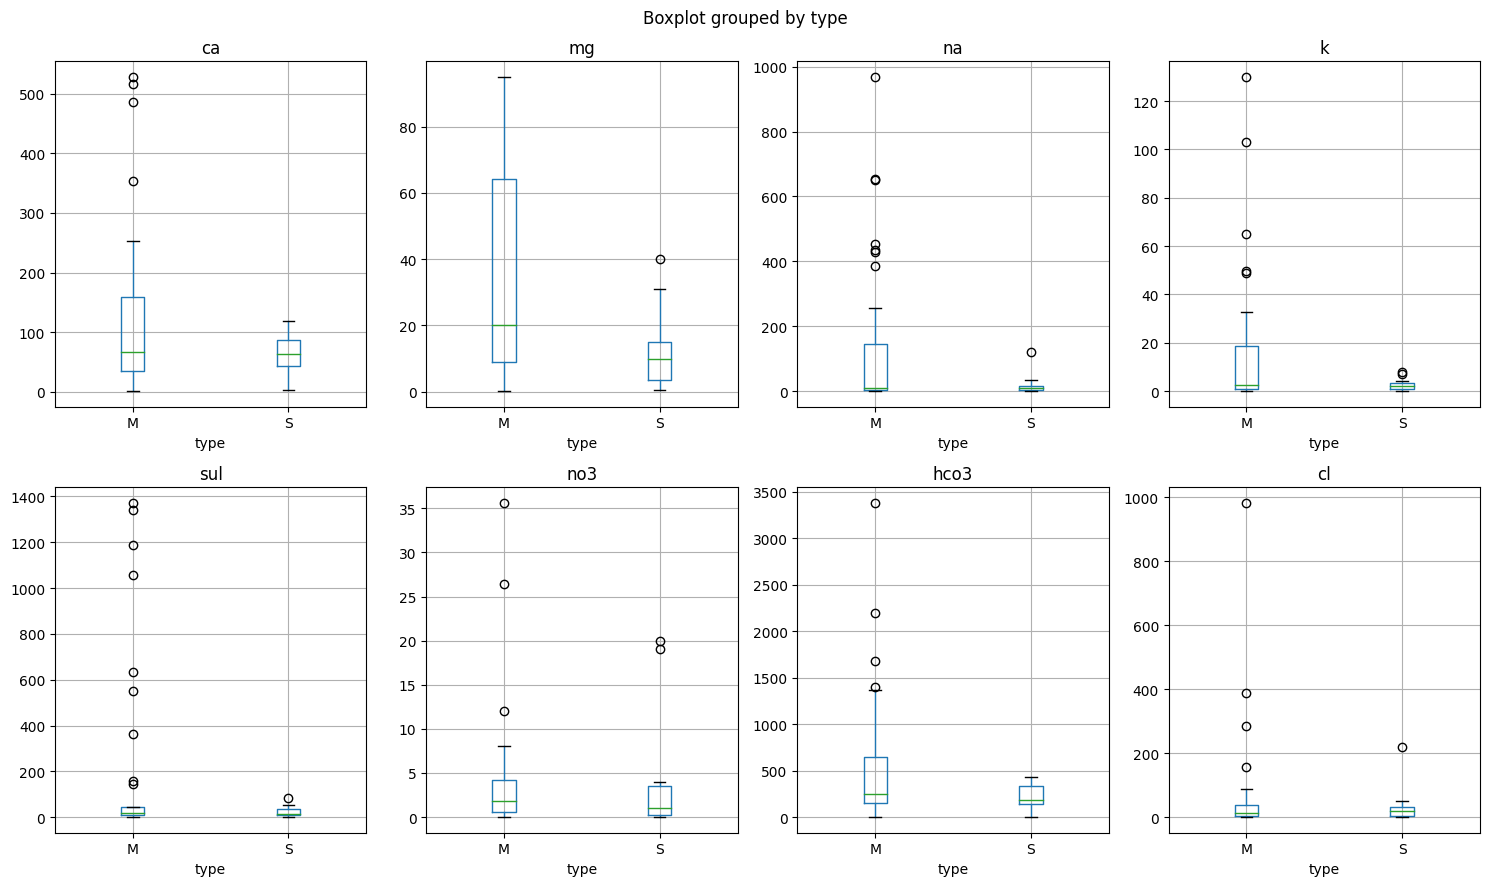

In [31]:
# boxplots entre la variable 'type' et les quanti

fig, axes = plt.subplots(2,4, figsize=(15,9))

for i,el in enumerate(list(df.loc[:,numeric_cols].columns)):
    a = df.boxplot(el, by="type", ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()


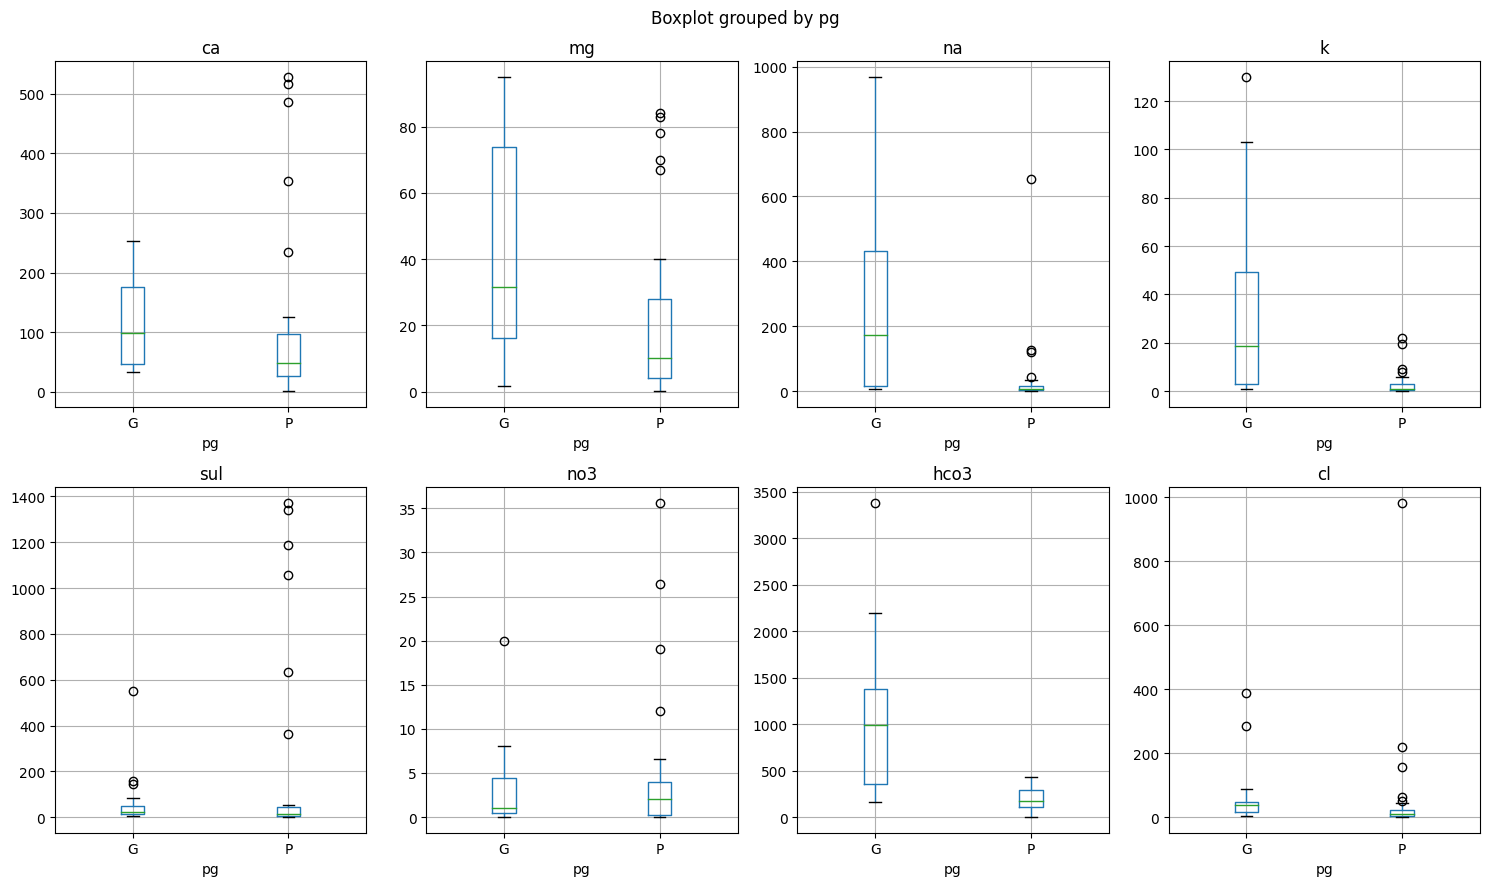

In [32]:
# boxplots entre la variable 'pg' et les quanti

fig, axes = plt.subplots(2,4, figsize=(15,9))

for i,el in enumerate(list(df.loc[:,numeric_cols].columns)):
    a = df.boxplot(el, by="pg", ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()


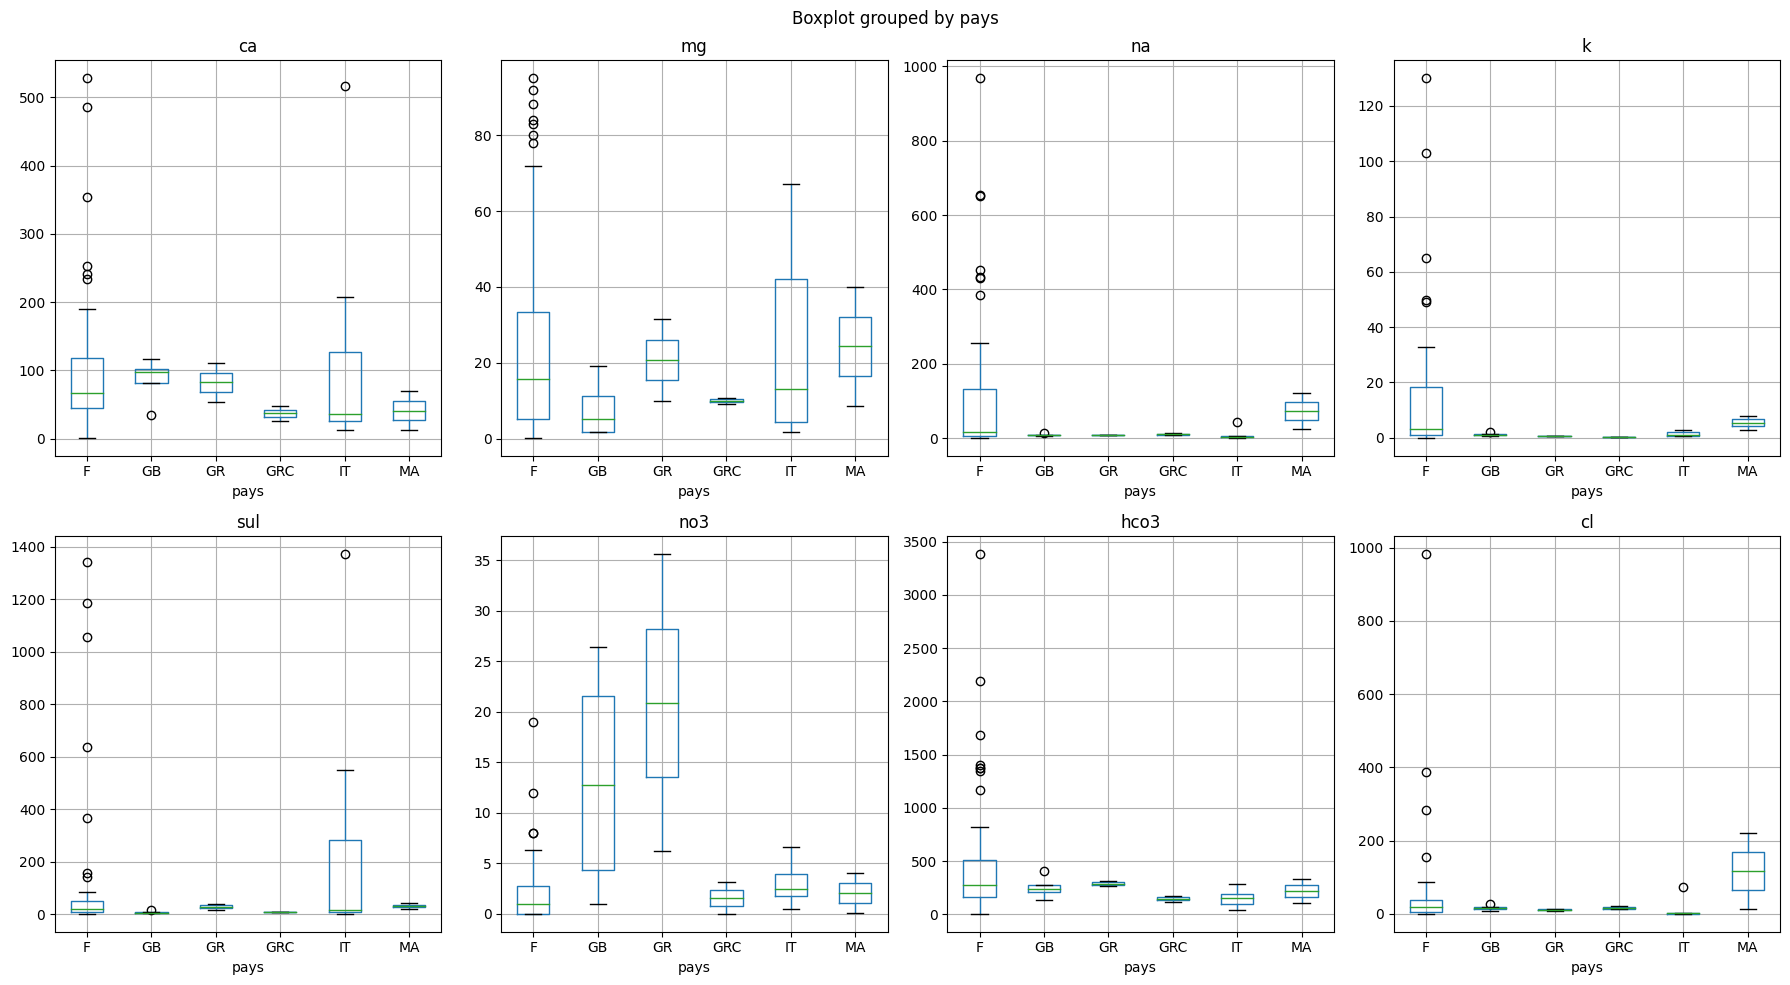

In [33]:
# boxplots entre la variable pays et les quanti

fig, axes = plt.subplots(2,4, figsize=(18,10))

for i,el in enumerate(list(df.loc[:,numeric_cols].columns)):
    a = df.boxplot(el, by="pays", ax=axes.flatten()[i])


plt.tight_layout() 

plt.show()


In [34]:
# Fonction pour calculer le rapport de corrélation
# https://stackoverflow.com/a/67906155

def correlation_ratio(categories, measurements):
        fcat, _ = pd.factorize(categories)
        cat_num = np.max(fcat)+1
        y_avg_array = np.zeros(cat_num)
        n_array = np.zeros(cat_num)
        
        for i in range(0,cat_num):
            cat_measures = measurements[np.argwhere(fcat == i).flatten()]
            n_array[i] = len(cat_measures)
            y_avg_array[i] = np.average(cat_measures)
        
        y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
        sce = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
        sct = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
        
        if sce == 0:
            eta_carre = 0.0
        else:
            eta_carre = sce/sct
        return eta_carre

In [35]:
# Calcul du rapport de corrélation entre modalités des variables qualitatives et les numériques

d = {}

for q in categorical_cols:
    dkey = f"etaCarre_{q}_x"
    dvals = {}
    
    for c in numeric_cols:
        dvals[c] = correlation_ratio(df[q].values, df[c].to_numpy())
    
    d[dkey] = dvals


In [36]:
df_rapport_corr = pd.DataFrame(d)
df_rapport_corr.T

,ca,mg,na,k,sul,no3,hco3,cl
etaCarre_pays_x,0.027799,0.050684,0.069915,0.066366,0.048170,0.417567,0.071613,0.031506
etaCarre_type_x,0.060388,0.120796,0.074960,0.065665,0.059053,0.003265,0.070782,0.013881
etaCarre_pg_x,0.004463,0.124130,0.258494,0.296800,0.014792,0.002231,0.420945,0.006264


In [37]:
# Matrice des corrélations
df.corr()

,ca,mg,na,k,sul,no3,hco3,cl
ca,1.000000,0.702722,0.117942,0.125355,0.913097,-0.063443,0.134949,0.276410
mg,0.702722,1.000000,0.607569,0.661132,0.605463,-0.212388,0.619772,0.481261
na,0.117942,0.607569,1.000000,0.836564,0.064296,-0.116240,0.856214,0.587521
k,0.125355,0.661132,0.836564,1.000000,-0.025156,-0.165928,0.881568,0.400440
sul,0.913097,0.605463,0.064296,-0.025156,1.000000,-0.156504,-0.069137,0.317819
no3,-0.063443,-0.212388,-0.116240,-0.165928,-0.156504,1.000000,-0.060390,-0.120170
hco3,0.134949,0.619772,0.856214,0.881568,-0.069137,-0.060390,1.000000,0.190623
cl,0.276410,0.481261,0.587521,0.400440,0.317819,-0.120170,0.190623,1.000000


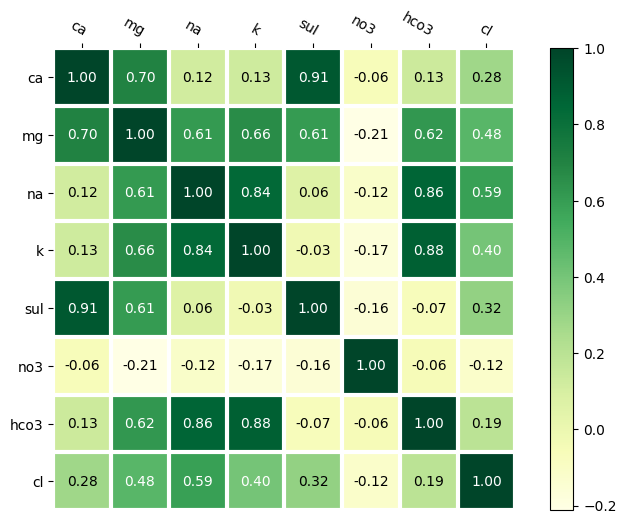

In [38]:
# Heatmap pour visualiser la matrice des corrélations (variables quanti uniquement)
corr = np.array(df.corr())

plt.figure(figsize=(9,6))
im, cbar = heatmap(corr, df.corr().columns, df.corr().columns, cmap="YlGn")
texts = annotate_heatmap(im)


In [39]:
# Matrice des corrélations de rang de Spearman
df.corr(method="spearman")

,ca,mg,na,k,sul,no3,hco3,cl
ca,1.000000,0.650699,0.283778,0.404583,0.665099,-0.113045,0.656822,0.394218
mg,0.650699,1.000000,0.599381,0.641442,0.720245,-0.156411,0.724797,0.560274
na,0.283778,0.599381,1.000000,0.786365,0.349210,-0.167108,0.571030,0.901475
k,0.404583,0.641442,0.786365,1.000000,0.463532,-0.339066,0.614521,0.643467
sul,0.665099,0.720245,0.349210,0.463532,1.000000,-0.384660,0.428928,0.349656
no3,-0.113045,-0.156411,-0.167108,-0.339066,-0.384660,1.000000,0.043652,-0.119100
hco3,0.656822,0.724797,0.571030,0.614521,0.428928,0.043652,1.000000,0.499627
cl,0.394218,0.560274,0.901475,0.643467,0.349656,-0.119100,0.499627,1.000000


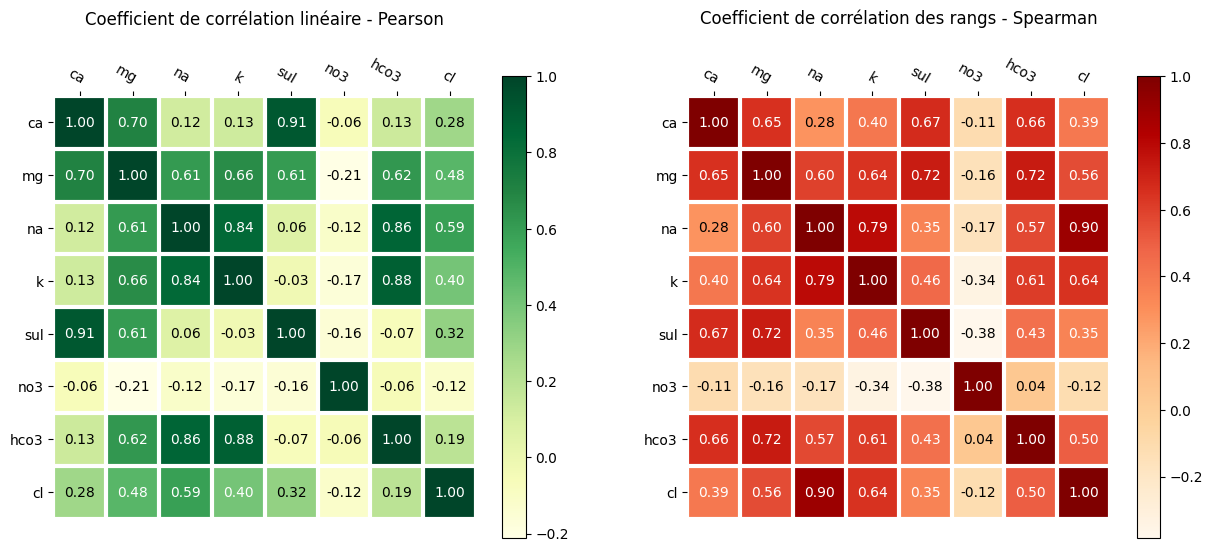

In [40]:
# Heatmap
corr = np.array(df.corr())
corr_spearman = np.array(df.corr(method="spearman"))

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
im, cbar = heatmap(corr, df.corr().columns, df.corr().columns, cmap="YlGn")
texts = annotate_heatmap(im)
plt.title("Coefficient de corrélation linéaire - Pearson", y=1.15)

plt.subplot(1,2,2)
im, cbar = heatmap(corr_spearman, df.corr(method="spearman").columns, df.corr(method="spearman").columns, cmap="OrRd")
texts = annotate_heatmap(im)
plt.title("Coefficient de corrélation des rangs - Spearman", y=1.15)

plt.show()

## <a id="analyse_exploratoire_multi" style="color:black">2-3. Analyse Multivariée : ACP (basée sur la SVD)</a>


In [41]:
n = df.shape[0]

p = df.drop(["nom","acronyme","pays","type","pg"], axis=1).shape[1]

In [42]:
## Standardisation

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
arr = sc.fit_transform(df.drop(["nom","acronyme","pays","type","pg"], axis=1))

In [43]:
arr

array([[-2.05676460e-01, -6.63812055e-02, -4.54453474e-01,
        -4.16612599e-01, -3.85100926e-01, -5.17507668e-03,
        -1.41252535e-01, -3.37872226e-01],
       [-4.57955135e-01, -5.29854995e-01, -3.06126063e-01,
        -4.16612599e-01, -3.66713375e-01,  2.50792177e-02,
        -4.29838332e-01, -1.74218262e-02],
       [-2.64541484e-01, -7.25940059e-01, -4.22742097e-01,
        -3.25778521e-01, -4.00423886e-01, -4.28735199e-01,
        -3.18716214e-01, -2.28707804e-01],
       [-1.13174279e-01,  1.83181604e-01, -3.93076614e-01,
        -3.75324382e-01, -2.71711024e-01, -5.80006671e-01,
        -1.36276917e-01, -1.72364876e-01],
       [-8.27122929e-01, -8.61417013e-01, -4.66217373e-01,
        -4.20741421e-01, -4.12375795e-01, -4.58989493e-01,
        -6.90560672e-01, -3.63226543e-01],
       [-1.46811436e-01,  1.93012127e+00,  1.48914709e+00,
         2.22583331e+00, -3.39132047e-01, -2.92590874e-01,
         1.50567676e+00,  1.63765166e+00],
       [-6.38754852e-01, -8.863732

In [44]:
# check moyenne = 0 pour chaque colonne
np.mean(arr, axis=0)

array([-5.45372714e-17, -2.14253566e-17, -5.84327908e-18, -5.74589109e-17,
        5.55111512e-17, -3.99290737e-17, -6.42760698e-17,  0.00000000e+00])

In [45]:
# check : écart-type = 1 pour chaque colonne
np.std(arr, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [46]:
from sklearn.decomposition import PCA

acp = PCA(svd_solver="full")
print(acp.__dict__)

{'n_components': None, 'copy': True, 'whiten': False, 'svd_solver': 'full', 'tol': 0.0, 'iterated_power': 'auto', 'random_state': None}


In [47]:
coords = acp.fit_transform(arr)
print(acp.n_components_)

8


In [ ]:
## Variance expliquée (=les valeurs propres)
val_propres = (acp.singular_values_**2/n)
val_propres

In [49]:
## Proportion de variance expliquée par chaque axe

ratio_expliq = acp.explained_variance_ratio_
np.round(ratio_expliq, 3)

array([0.477, 0.259, 0.122, 0.1  , 0.022, 0.012, 0.009, 0.   ])

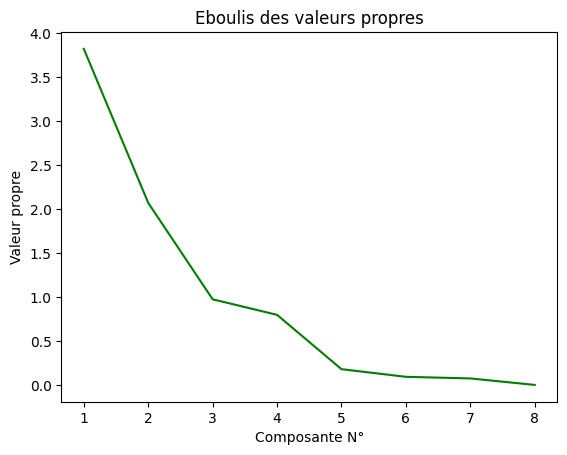

In [50]:
abcisse = np.arange(1, p+1)

plt.plot(abcisse, val_propres, "g-")
plt.title("Eboulis des valeurs propres")
plt.xlabel("Composante N°")
plt.ylabel("Valeur propre")
plt.show()

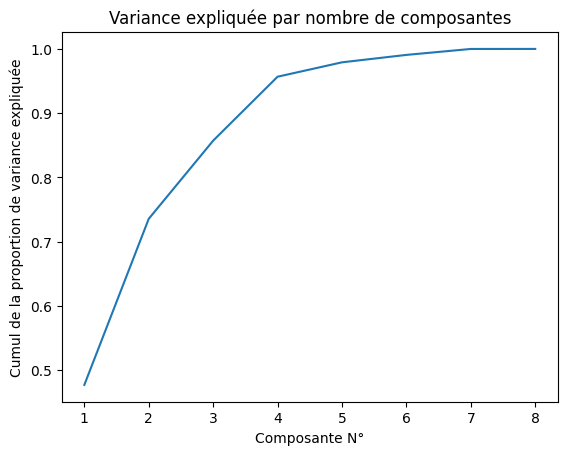

In [51]:
plt.plot(abcisse,np.cumsum(ratio_expliq))
plt.title("Variance expliquée par nombre de composantes")
plt.ylabel("Cumul de la proportion de variance expliquée")
plt.xlabel("Composante N°")
plt.show()

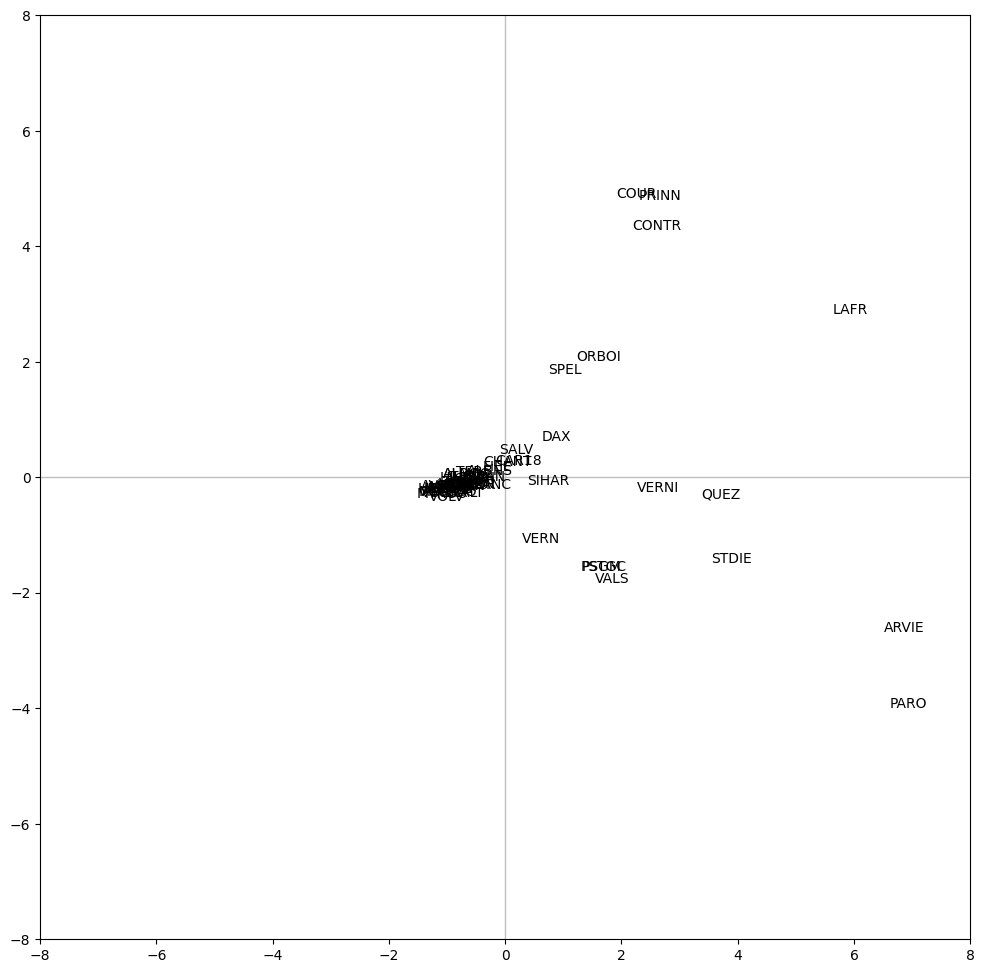

In [52]:
## Premier plan factoriel
fig, axes = plt.subplots(figsize=(12,12)) 
axes.set_xlim(-8,8)
axes.set_ylim(-8,8)

for i in range(n):
    plt.annotate(df.acronyme[i], (coords[i,0], coords[i,1]))

plt.plot([-8,8], [0,0], color="silver", linestyle="-", linewidth=1)
plt.plot([0,0], [-8,8], color="silver", linestyle="-", linewidth=1)

plt.show()

In [53]:
## COS² individus
di = np.sum(arr**2, axis=1)
df_dists_i = pd.DataFrame({"acronyme":df.acronyme, "di":di})

cos2 = coords**2

for j in range(p):
    cos2[:,j] = cos2[:,j]/di

dict_cos2 = {f"COS2_{x+1}":cos2[:,x] for x in range(p)}

df_cos2 = pd.DataFrame(dict({"acronyme":df.acronyme}, **dict_cos2))


In [54]:
# check somme des COS² par ligne = 1
np.sum(cos2, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [55]:
df_cos2.sort_values(["COS2_1","COS2_2"], ascending=False)

,acronyme,COS2_1,COS2_2,COS2_3,COS2_4,COS2_5,COS2_6,COS2_7,COS2_8
29,STANT,0.938345,0.041831,0.008985,0.005072,0.000234,0.001479,0.004055,1.013090e-06
28,VERA,0.925561,0.023484,0.031452,0.000459,0.003547,0.007313,0.008175,8.843194e-06
56,MTCLA,0.905900,0.026685,0.050350,0.003715,0.003874,0.009425,0.000049,2.211547e-06
45,PYR,0.896712,0.033075,0.018814,0.048517,0.000017,0.002556,0.000017,2.925126e-04
23,ROUV,0.878542,0.033829,0.061140,0.011419,0.001020,0.003606,0.010444,1.247536e-09
8,ALMO,0.870539,0.000059,0.123433,0.002682,0.001102,0.001633,0.000543,7.675568e-06
11,ALROC,0.870539,0.000059,0.123433,0.002682,0.001102,0.001633,0.000543,7.675568e-06
39,OGEU,0.868798,0.034213,0.019896,0.075897,0.000076,0.000727,0.000391,4.689406e-07
24,ALIS,0.848266,0.036143,0.081726,0.010730,0.001420,0.004591,0.017123,3.523612e-07
1,MTPYR,0.843192,0.035208,0.020815,0.099101,0.000138,0.000783,0.000752,9.456583e-06


In [56]:
## Contribution des individus à la construction des axes
ctr = coords**2

for j in range(p):
    ctr[:,j] = ctr[:,j]/(n*val_propres[j])

dict_ctr = {f"CTR_{x+1}":ctr[:,x] for x in range(p)}

df_ctr = pd.DataFrame(dict({"acronyme":df.acronyme}, **dict_ctr))


In [57]:
# check somme des CTR par colonne = 1
np.sum(ctr, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [58]:
df_ctr.sort_values(["CTR_1","CTR_2"], ascending=False)

,acronyme,CTR_1,CTR_2,CTR_3,CTR_4,CTR_5,CTR_6,CTR_7,CTR_8
41,PARO,0.200790,1.347671e-01,0.002947,5.479854e-02,1.161539e-01,0.001043,0.006430,8.952163e-02
10,ARVIE,0.195026,6.051690e-02,0.000184,2.632714e-03,1.536434e-01,0.234751,0.004590,6.075300e-02
30,LAFR,0.146271,6.786878e-02,0.003622,6.132548e-01,2.953413e-02,0.004425,0.020212,2.314832e-03
5,STDIE,0.057704,1.850164e-02,0.000292,6.831194e-03,8.869559e-02,0.013388,0.005984,2.661585e-01
18,QUEZ,0.052220,1.113314e-03,0.000557,5.363432e-02,6.030327e-02,0.064832,0.043572,6.521078e-02
47,PRINN,0.024061,1.957660e-01,0.000925,4.721405e-02,1.077973e-02,0.012180,0.003105,1.690538e-02
42,VERNI,0.023690,5.577176e-04,0.000681,3.560775e-02,7.554831e-02,0.000243,0.000483,5.084409e-02
15,CONTR,0.021888,1.563679e-01,0.005890,4.315738e-02,4.955279e-04,0.001375,0.002509,5.599524e-04
44,COUR,0.016642,1.981552e-01,0.003821,3.703623e-02,2.073220e-02,0.048465,0.018469,2.044990e-03
52,VALS,0.010932,2.811003e-02,0.001004,4.046092e-03,1.290694e-01,0.004462,0.001328,8.285589e-03


On s'intéresse ici aux contributions des individus à la construction des deux premiers axes.  

En théorie, plus CTR est élevé, plus l'individu pèse dans la détermination de l'axe.  
Sur le 1er Axe, les eaux ayant le + contribué sont :  
- PARO
- ARVIE (Arvie)
- LAFR  (La Française)

Sur l'Axe 2, les eaux ayant le + contribué sont : 
- COUR  (Courmayeur)
- PRINN (Prince Noir)
- CONTR (Contrex)
- PARO  (Parot)


In [59]:
## Représentation des variables et outils d'aide à l'interprétation

vec_propres = acp.components_
sqrt_valprop = np.sqrt(val_propres)
corr_var_cp = np.zeros((p,p))

for k in range(p):
    corr_var_cp[:,k] = vec_propres[k,:] * sqrt_valprop[k]

dict_corrvarcp = {f"COR_CP_{x+1}":corr_var_cp[:,x] for x in range(p)}
df_corrvarcp = pd.DataFrame(dict({"variables":df.drop(["nom","acronyme","pays","type","pg"], axis=1).columns}, **dict_corrvarcp)) 


In [60]:
df_corrvarcp.sort_values(["COR_CP_1","COR_CP_2"], ascending=False)

,variables,COR_CP_1,COR_CP_2,COR_CP_3,COR_CP_4,COR_CP_5,COR_CP_6,COR_CP_7,COR_CP_8
1,mg,0.910457,0.254406,0.036883,-0.148158,0.196247,-0.205927,-0.045909,-0.002714
2,na,0.855162,-0.414277,0.033126,0.154392,-0.262944,-0.026462,-0.046904,-0.009900
3,k,0.835467,-0.458474,-0.005010,-0.106366,0.190470,0.192743,-0.083830,-0.000852
6,hco3,0.784039,-0.498896,0.129768,-0.311400,-0.102477,-0.033304,0.104091,0.011447
7,cl,0.620400,0.095034,-0.069703,0.769756,0.064270,0.003196,0.067283,0.004709
0,ca,0.549600,0.776415,0.170495,-0.178098,-0.005109,0.095134,0.158781,-0.006620
4,sul,0.449668,0.867580,0.031461,-0.029495,-0.141085,0.044572,-0.145926,0.007626
5,no3,-0.233795,-0.090004,0.958424,0.130604,0.026621,-0.003798,-0.029706,0.000162


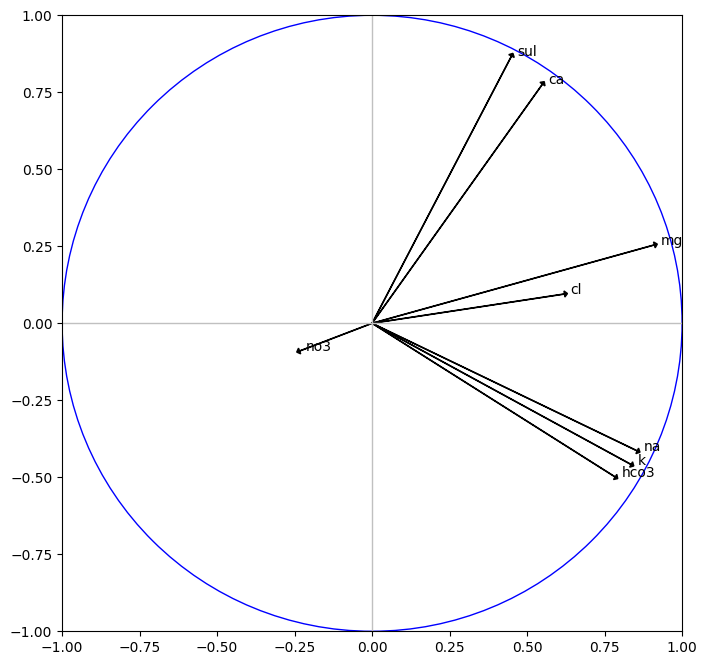

In [61]:
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

for j in range(p):
    plt.annotate(df_corrvarcp.iloc[j,0], (df_corrvarcp.iloc[j,1] + 0.02,df_corrvarcp.iloc[j,2]))
    plt.arrow(0,0,df_corrvarcp.iloc[j,1],df_corrvarcp.iloc[j,2],head_width=0.02, head_length=0.01, fc="k")

plt.plot([-1,1], [0,0], color='silver', linestyle='-', linewidth=1)
plt.plot([0,0], [-1,1], color='silver', linestyle='-', linewidth=1)

cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

plt.show()

In [62]:
## COS² (variables)
df_cosvaracp = df_corrvarcp.copy()
df_cosvaracp.iloc[:,1:] = df_cosvaracp.iloc[:,1:]**2

dict_rename = {f"COR_CP_{x+1}":f"COS_VAR_CP{x+1}" for x in range(p)}
df_cosvaracp.rename(columns=dict_rename, inplace=True)

In [63]:
# check somme des cosinus pour chaque ligne = 1

df_cosvaracp.sum(axis=1)

C:\Users\Nelly\AppData\Local\Temp\ipykernel_15712\3036462373.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_cosvaracp.sum(axis=1)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
dtype: float64

In [64]:
df_cosvaracp.sort_values("COS_VAR_CP2", ascending=False)

,variables,COS_VAR_CP1,COS_VAR_CP2,COS_VAR_CP3,COS_VAR_CP4,COS_VAR_CP5,COS_VAR_CP6,COS_VAR_CP7,COS_VAR_CP8
4,sul,0.202201,0.752695,0.000990,0.000870,0.019905,0.001987,0.021294,5.815403e-05
0,ca,0.302061,0.602820,0.029069,0.031719,0.000026,0.009050,0.025211,4.382251e-05
6,hco3,0.614717,0.248897,0.016840,0.096970,0.010502,0.001109,0.010835,1.310263e-04
3,k,0.698006,0.210198,0.000025,0.011314,0.036279,0.037150,0.007027,7.262174e-07
2,na,0.731302,0.171625,0.001097,0.023837,0.069140,0.000700,0.002200,9.800658e-05
1,mg,0.828933,0.064722,0.001360,0.021951,0.038513,0.042406,0.002108,7.367291e-06
7,cl,0.384896,0.009031,0.004858,0.592524,0.004131,0.000010,0.004527,2.217658e-05
5,no3,0.054660,0.008101,0.918576,0.017057,0.000709,0.000014,0.000882,2.627363e-08


In [65]:
## Contribution (variables)

# calcul de la CTR des variables : on divise le COS² trouvé ci-avant par la valeur propre
df_ctrvar = df_cosvaracp.copy()
for k in range(p):
    df_ctrvar.iloc[:,k+1] = df_ctrvar.iloc[:,k+1]/val_propres[k]

# on modifie les noms des variables
dict_rename = {f"COS_VAR_CP{x+1}":f"CTR_VAR_CP{x+1}" for x in range(p)}
df_ctrvar.rename(columns=dict_rename, inplace=True)


In [66]:
# check la somme des contributions de chaque variable = 1 (chaque ligne)
df_ctrvar.sum(axis=1)

C:\Users\Nelly\AppData\Local\Temp\ipykernel_15712\1777684595.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_ctrvar.sum(axis=1)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
dtype: float64

In [67]:
df_ctrvar.sort_values("CTR_VAR_CP2", ascending=False)

,variables,CTR_VAR_CP1,CTR_VAR_CP2,CTR_VAR_CP3,CTR_VAR_CP4,CTR_VAR_CP5,CTR_VAR_CP6,CTR_VAR_CP7,CTR_VAR_CP8
4,sul,0.052977,0.363956,0.001017,0.001093,0.111075,0.021494,0.287432,0.160955
0,ca,0.079140,0.291486,0.029881,0.039836,0.000146,0.097920,0.340302,0.121289
6,hco3,0.161057,0.120351,0.017310,0.121785,0.058601,0.012000,0.146249,0.362647
3,k,0.182878,0.101639,0.000026,0.014209,0.202446,0.401937,0.094856,0.002010
2,na,0.191602,0.082987,0.001128,0.029937,0.385817,0.007576,0.029696,0.271257
1,mg,0.217181,0.031296,0.001398,0.027568,0.214911,0.458805,0.028449,0.020391
7,cl,0.100843,0.004367,0.004994,0.744151,0.023050,0.000110,0.061105,0.061379
5,no3,0.014321,0.003917,0.944245,0.021422,0.003955,0.000156,0.011911,0.000073


### <a id="analyse_exploratoire_multi_varsupp" style="color:black">2-3-1. Ajout des Variables illustratives</a>


#### Variables supplémentaires qualitatives

In [68]:
var_supp_quali = df.loc[:, ["acronyme","pays","type","pg"]]
var_supp_quali

,acronyme,pays,type,pg
0,EVIAN,F,M,P
1,MTPYR,F,S,P
2,CRIST,F,S,P
3,FIEE,F,S,P
4,VOLCA,F,S,P
5,STDIE,F,M,G
6,LUCHO,F,M,P
7,VOLV,F,M,P
8,ALMO,F,S,P
9,ORBOI,F,M,P


In [69]:
modalites_pays = var_supp_quali.pays.unique()
modalites_type = var_supp_quali.type.unique()
modalites_pg = var_supp_quali.pg.unique()

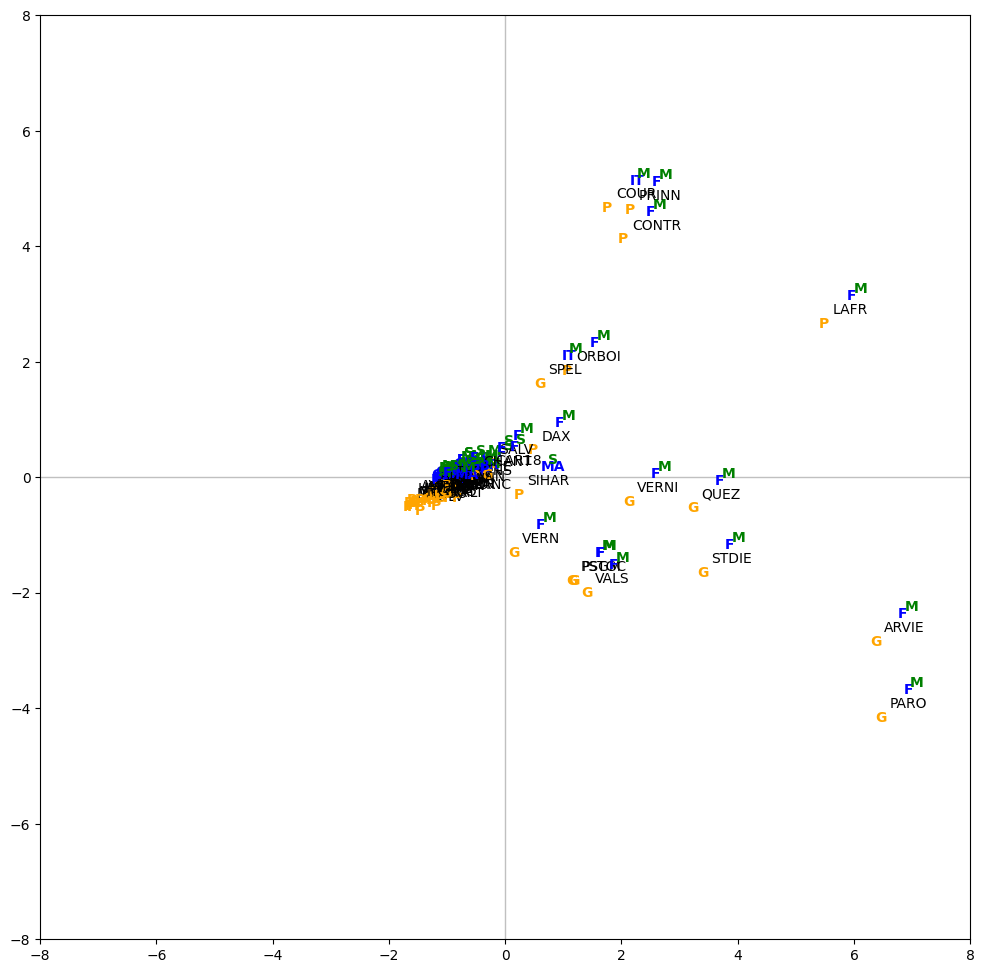

In [70]:
# Modalités la variable supplémentaire sur le plan factoriel

fig, axes = plt.subplots(figsize=(12,12)) 
axes.set_xlim(-8,8) # limites idem en abcisse/ordonnée
axes.set_ylim(-8,8)

for i in range(n):
    plt.annotate(df.acronyme[i], (coords[i,0], coords[i,1]))
    plt.annotate(df.pays[i], (coords[i,0], coords[i,1]), xytext=(10,10), textcoords="offset points",\
                 c="blue", weight="bold")
    plt.annotate(df.type[i], (coords[i,0], coords[i,1]), xytext=(15,15), textcoords="offset points",\
                 c="green", weight="bold")
    plt.annotate(df.pg[i], (coords[i,0], coords[i,1]), xytext=(-10,-10), textcoords="offset points",\
                 c="orange", weight="bold")

plt.plot([-8,8], [0,0], color="silver", linestyle="-", linewidth=1)
plt.plot([0,0], [-8,8], color="silver", linestyle="-", linewidth=1)

plt.show()

In [ ]:
## Calcul des positions des barycentres
df2 = pd.DataFrame({"pays":var_supp_quali.pays,"type":var_supp_quali.type,"pg":var_supp_quali.pg,\
                    "CP1":coords[:,0],"CP2":coords[:,1]})

In [71]:
# Barycentres par modalité de pays
df2.pivot_table(index="pays", values=["CP1","CP2"], aggfunc="mean")

,CP1,CP2
pays,,
F,0.331870,-0.091576
GB,-1.171231,-0.164111
GR,-1.088376,-0.153853
GRC,-1.120149,-0.191357
IT,-0.492230,0.773166
MA,-0.363605,-0.201130


In [72]:
# Barycentres par modalités de type
df2.pivot_table(index="type", values=["CP1","CP2"], aggfunc="mean")

,CP1,CP2
type,,
M,0.462312,0.06513
S,-0.924625,-0.13026


In [73]:
# Barycentres par modalités de pg
df2.pivot_table(index="pg", values=["CP1","CP2"], aggfunc="mean")

,CP1,CP2
pg,,
G,1.443390,-0.819637
P,-0.563274,0.319858


In [74]:
G_pays = df2.pivot_table(index="pays", values=["CP1","CP2"], aggfunc="mean")
G_type = df2.pivot_table(index="type", values=["CP1","CP2"], aggfunc="mean")
G_pg   = df2.pivot_table(index="pg", values=["CP1","CP2"], aggfunc="mean")

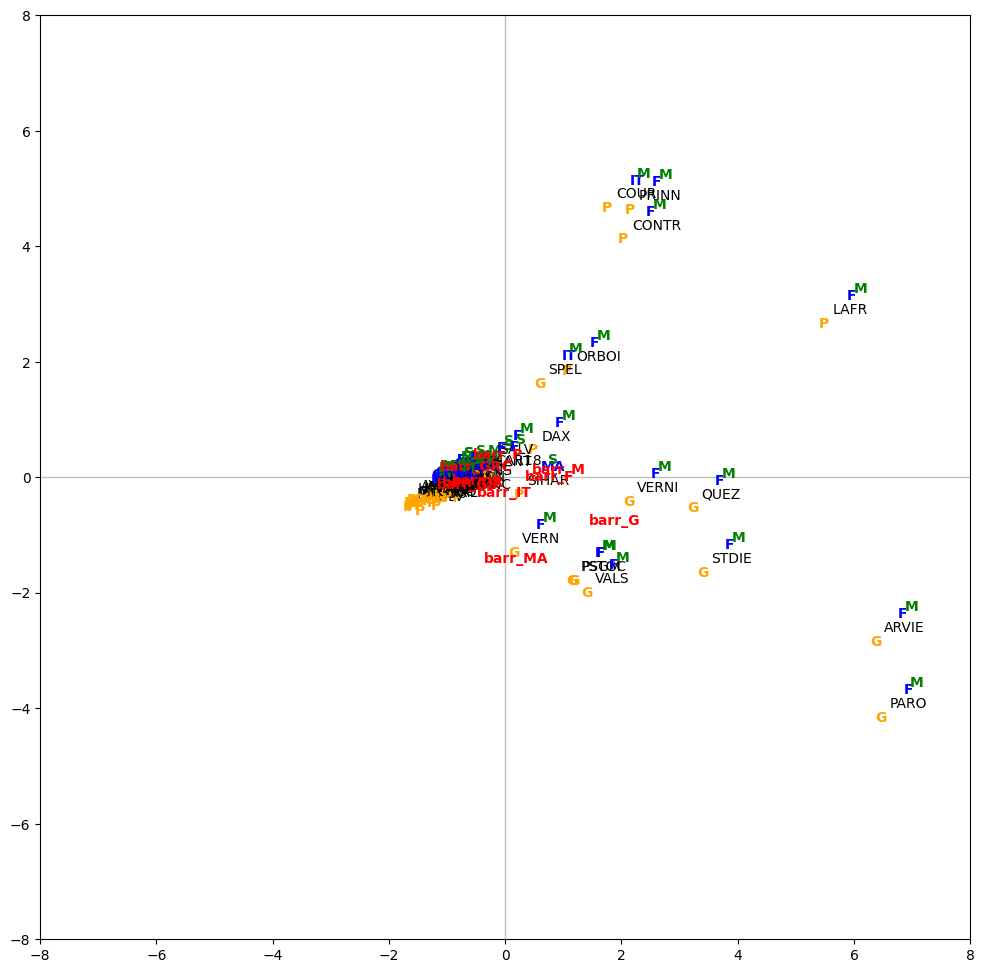

In [75]:
fig, axes = plt.subplots(figsize=(12,12)) 
axes.set_xlim(-8,8)
axes.set_ylim(-8,8)

for i in range(n):
    plt.annotate(df.acronyme[i], (coords[i,0], coords[i,1]))
    plt.annotate(df.pays[i], (coords[i,0], coords[i,1]), xytext=(10,10), textcoords="offset points",\
                 c="blue", weight="bold")
    plt.annotate(df.type[i], (coords[i,0], coords[i,1]), xytext=(15,15), textcoords="offset points",\
                 c="green", weight="bold")
    plt.annotate(df.pg[i], (coords[i,0], coords[i,1]), xytext=(-10,-10), textcoords="offset points",\
                 c="orange", weight="bold")

for i in range(len(G_pays)):
    plt.annotate(f"barr_{G_pays.index[i]}", (G_pays.iloc[i,0], coords[i,1]), c="red", weight="bold")

for i in range(len(G_type)):
    plt.annotate(f"barr_{G_type.index[i]}", (G_type.iloc[i,0], G_type.iloc[i,1]), c="red", weight="bold")
    plt.annotate(f"barr_{G_pg.index[i]}", (G_pg.iloc[i,0], G_pg.iloc[i,1]), c="red", weight="bold")

plt.plot([-8,8], [0,0], color="silver", linestyle="-", linewidth=1)
plt.plot([0,0], [-8,8], color="silver", linestyle="-", linewidth=1)

plt.show()

In [76]:
df2[df2.pays == 'IT']

,pays,type,pg,CP1,CP2
24,IT,M,P,-1.435902,-0.296396
25,IT,M,P,-0.828035,-0.182062
26,IT,M,G,0.741737,1.787930
27,IT,M,P,-1.382483,-0.273812
28,IT,M,P,-1.145004,-0.182387
29,IT,M,P,-1.298681,-0.274201
44,IT,M,P,1.902755,4.833090


In [77]:
# Calcul des ecart-type par groupe et composante

G_std_pays = df2.pivot_table(index="pays", values=["CP1","CP2"], aggfunc=["mean","std"])
G_std_pays.columns = ['_'.join(col) for col in G_std_pays.columns]  #pour renommer les colonnes et retirer 1 niveau

G_std_type = df2.pivot_table(index="type", values=["CP1","CP2"], aggfunc=["mean","std"])
G_std_type.columns = ['_'.join(col) for col in G_std_type.columns]  #pour renommer les colonnes

G_std_pg   = df2.pivot_table(index="pg", values=["CP1","CP2"], aggfunc=["mean","std"])
G_std_pg.columns = ['_'.join(col) for col in G_std_pg.columns]  #pour renommer les colonnes

In [78]:
G_std_pays

,mean_CP1,mean_CP2,std_CP1,std_CP2
pays,,,,
F,0.331870,-0.091576,2.202041,1.521880
GB,-1.171231,-0.164111,0.258146,0.091794
GR,-1.088376,-0.153853,0.513126,0.096721
GRC,-1.120149,-0.191357,0.107291,0.061287
IT,-0.492230,0.773166,1.299419,1.944024
MA,-0.363605,-0.201130,1.052819,0.098016


In [79]:
# Calcul des valeurs test

G_std_pays["vtest_CP1"] = G_std_pays.mean_CP1/G_std_pays.std_CP1
G_std_pays["vtest_CP2"] = G_std_pays.mean_CP2/G_std_pays.std_CP2

G_std_type["vtest_CP1"] = G_std_type.mean_CP1/G_std_type.std_CP1
G_std_type["vtest_CP2"] = G_std_type.mean_CP2/G_std_type.std_CP2

G_std_pg["vtest_CP1"] = G_std_pg.mean_CP1/G_std_pg.std_CP1
G_std_pg["vtest_CP2"] = G_std_pg.mean_CP2/G_std_pg.std_CP2

In [80]:
G_std_pays

,mean_CP1,mean_CP2,std_CP1,std_CP2,vtest_CP1,vtest_CP2
pays,,,,,,
F,0.331870,-0.091576,2.202041,1.521880,0.150710,-0.060173
GB,-1.171231,-0.164111,0.258146,0.091794,-4.537084,-1.787825
GR,-1.088376,-0.153853,0.513126,0.096721,-2.121070,-1.590677
GRC,-1.120149,-0.191357,0.107291,0.061287,-10.440325,-3.122284
IT,-0.492230,0.773166,1.299419,1.944024,-0.378808,0.397714
MA,-0.363605,-0.201130,1.052819,0.098016,-0.345363,-2.052011


In [81]:
G_std_type

,mean_CP1,mean_CP2,std_CP1,std_CP2,vtest_CP1,vtest_CP2
type,,,,,,
M,0.462312,0.06513,2.26057,1.777077,0.204511,0.036650
S,-0.924625,-0.13026,0.47808,0.175042,-1.934038,-0.744164


In [82]:
G_std_pg

,mean_CP1,mean_CP2,std_CP1,std_CP2,vtest_CP1,vtest_CP2
pg,,,,,,
G,1.443390,-0.819637,2.484587,1.365787,0.580937,-0.600121
P,-0.563274,0.319858,1.401929,1.368914,-0.401785,0.233658


## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.8</span>

Requirements.txt  

```
absl-py==2.1.0
anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0       
arrow==1.2.3
asttokens==2.4.0
astunparse==1.6.3
async-lru==2.0.4
attrs==23.1.0
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.0.0
cachetools==4.2.4
certifi==2023.7.22
cffi==1.15.1
charset-normalizer==2.0.12
colorama==0.4.6
comm==0.1.4
cycler==0.11.0
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
exceptiongroup==1.1.3
executing==1.2.0
fastjsonschema==2.18.0
fonttools==4.42.1
fqdn==1.5.1
gast==0.3.3
google-auth==1.35.0
google-auth-oauthlib==0.4.6        
google-pasta==0.2.0
grpcio==1.66.2
h5py==2.10.0
htmlmin==0.1.12
idna==3.4
ImageHash==4.3.1
importlib-metadata==8.5.0
importlib-resources==6.4.5
ipykernel==6.25.2
ipython==8.12.0
ipython-genutils==0.2.0
ipywidgets==8.1.1
isoduration==20.11.0
jedi==0.19.0
Jinja2==3.1.2
joblib==1.1.1
json5==0.9.14
jsonpointer==2.4
jsonschema==4.19.0
jsonschema-specifications==2023.7.1
jupyter==1.0.0
jupyter-client==8.3.1
jupyter-console==6.6.3
jupyter-core==5.3.1
jupyter-events==0.7.0
jupyter-lsp==2.2.0
jupyter-server==2.7.3
jupyter-server-terminals==0.4.4
jupyterlab==4.0.6
jupyterlab-pygments==0.2.2
jupyterlab-server==2.25.0
jupyterlab-widgets==3.0.9
Keras==2.4.3
Keras-Preprocessing==1.1.2
kiwisolver==1.4.5
Markdown==3.7
MarkupSafe==2.1.3
matplotlib==3.5.3
matplotlib-inline==0.1.6
missingno==0.5.2
mistune==3.0.1
multimethod==1.8
nbclient==0.8.0
nbconvert==7.8.0
nbformat==5.9.2
nest-asyncio==1.5.8
networkx==3.1
notebook==7.0.3
notebook-shim==0.2.3
numpy==1.22.0
oauthlib==3.2.2
opt-einsum==3.4.0
overrides==7.4.0
packaging==23.1
pandas==1.4.0
pandas-profiling==3.3.0
pandocfilters==1.5.0
parso==0.8.3
patsy==0.5.3
pexpect==4.8.0
phik==0.12.3
pickleshare==0.7.5
Pillow==10.0.1
pkgutil-resolve-name==1.3.10
platformdirs==3.10.0
prometheus-client==0.17.1
prompt-toolkit==3.0.39
protobuf==3.20.3
psutil==5.9.5
ptyprocess==0.7.0
pure-eval==0.2.2
pyasn1==0.6.1
pyasn1-modules==0.4.1
pycparser==2.21
pydantic==1.9.2
Pygments==2.16.1
pyparsing==3.1.1
python-dateutil==2.8.2
python-json-logger==2.0.7
pytz==2023.3.post1
PyWavelets==1.4.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==25.1.1
qtconsole==5.4.4
QtPy==2.4.0
referencing==0.30.2
requests==2.28.0
requests-oauthlib==2.0.0
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.10.3
rsa==4.9
scikit-learn==0.23.2
scipy==1.4.1
seaborn==0.11.2
Send2Trash==1.8.2
six==1.16.0
sniffio==1.3.0
soupsieve==2.5
stack-data==0.6.2
statsmodels==0.13.5
tangled-up-in-unicode==0.2.0
tensorboard==2.2.2
tensorboard-plugin-wit==1.8.1
tensorflow==2.2.0
tensorflow-estimator==2.2.0
termcolor==2.4.0
terminado==0.17.1
threadpoolctl==3.5.0
tinycss2==1.2.1
tomli==2.0.1
tornado==6.3.3
tqdm==4.64.1
traitlets==5.10.0
typing-extensions==4.7.1
uri-template==1.3.0
urllib3==1.26.16
visions==0.7.5
wcwidth==0.2.6
webcolors==1.13
webencodings==0.5.1
websocket-client==1.6.3
werkzeug==3.0.4
widgetsnbextension==4.0.9
wrapt==1.16.0
xlrd==2.0.1
zipp==3.20.2
```